In [1]:
!pip install influxdb_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.3/746.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 16.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/Time_Series_V28'

Mounted at /content/drive
/content/drive/My Drive/Time_Series_V28


In [4]:
import tensorflow as tf

# Corrected import for register_keras_serializable
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable() # Use the imported decorator directly
class TwoSidedAsymmetricHuberLoss(tf.keras.losses.Loss):
    """
    A custom two-sided asymmetric Huber loss function with value-dependent penalties.

    This loss penalizes:
    - Underpredictions (y_pred < y_true) more, especially when y_true is high (spikes).
    - Overpredictions (y_pred > y_true) more, especially when y_true is low (troughs/negative prices).
    """
    def __init__(self,
                 delta,
                 base_under_penalty_factor,
                 peak_penalty_scalar,
                 base_over_penalty_factor,
                 trough_penalty_scalar,
                 name="TwoSidedAsymmetricHuberLoss",
                 **kwargs):
        super().__init__(name=name)
        # Store all hyperparameters as attributes of the class
        self.delta = delta
        self.base_under_penalty_factor = base_under_penalty_factor
        self.peak_penalty_scalar = peak_penalty_scalar
        self.base_over_penalty_factor = base_over_penalty_factor
        self.trough_penalty_scalar = trough_penalty_scalar

    # This method defines the forward pass (how the loss is calculated)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.math.abs(error)

        # Huber loss core
        quadratic_part = 0.5 * tf.math.square(error)
        linear_part = self.delta * abs_error - 0.5 * tf.math.square(self.delta)
        huber_loss_per_sample = tf.where(abs_error <= self.delta, quadratic_part, linear_part)

        # Masks for underpredictions and overpredictions
        # error > 0 means y_true > y_pred (underprediction)
        underprediction_mask = tf.cast(tf.math.greater(error, 0), tf.float32)
        # error <= 0 means y_true <= y_pred (overprediction or exact prediction)
        overprediction_mask = tf.cast(tf.math.less_equal(error, 0), tf.float32)

        # Dynamic penalty for UNDERPREDICTIONS (missing high spikes)
        # Penalty increases as y_true (normalized price) gets higher
        dynamic_under_penalty = self.base_under_penalty_factor + (y_true * self.peak_penalty_scalar)

        # Dynamic penalty for OVERPREDICTIONS (missing low spikes/troughs)
        # Penalty increases as y_true (normalized price) gets LOWER.
        # (1.0 - y_true) is large when y_true is small (near 0) and small when y_true is large (near 1).
        dynamic_over_penalty = self.base_over_penalty_factor + ((1.0 - y_true) * self.trough_penalty_scalar)

        # Apply the dynamic asymmetric weighting
        asymmetric_loss = (underprediction_mask * dynamic_under_penalty * huber_loss_per_sample) + \
                          (overprediction_mask * dynamic_over_penalty * huber_loss_per_sample)

        # Return the mean loss across the batch
        return tf.reduce_mean(asymmetric_loss)

    # This method is crucial for serialization: it tells Keras how to reconstruct the object
    # when loading a saved model. It should return a dictionary containing the arguments
    # needed to re-instantiate the class.
    def get_config(self):
        config = super().get_config() # Get the base config from the parent class
        config.update({
            "delta": self.delta,
            "base_under_penalty_factor": self.base_under_penalty_factor,
            "peak_penalty_scalar": self.peak_penalty_scalar,
            "base_over_penalty_factor": self.base_over_penalty_factor,
            "trough_penalty_scalar": self.trough_penalty_scalar,
        })
        return config

delta = 0.01 # Huber transition point (tune around normalized MAE)
base_under_penalty_factor = 1.0 # Minimum multiplier for underpredictions
peak_penalty_scalar = 5.0       # Higher values mean stronger penalty for missing HIGH peaks

# For overpredicting low spikes/troughs:
base_over_penalty_factor = 1.3  # Minimum multiplier for overpredictions
trough_penalty_scalar = 4.5      # Higher values mean stronger penalty for overpredicting LOW troughs

# 2. Create an instance of custom loss function using the factory
# This call returns the '_loss_fn' function itself.
custom_loss_callable = TwoSidedAsymmetricHuberLoss(
    delta=delta,
    base_under_penalty_factor=base_under_penalty_factor,
    peak_penalty_scalar=peak_penalty_scalar,
    base_over_penalty_factor=base_over_penalty_factor,
    trough_penalty_scalar=trough_penalty_scalar
)

In [5]:
#loading the trained model and fitted scaler
from tensorflow.keras.models import load_model
import joblib

model = load_model("lstm_price_forecasting_univariate_v28.keras")
X_scaler = joblib.load('univariate_minmax_X_scaler_v28.gz')
y_scaler = joblib.load('univariate_minmax_Y_scaler_v28.gz')

In [6]:
''' Creating the connection with the influx database '''

from influxdb_client import InfluxDBClient

# Define your InfluxDB connection parameters
url = "http://kammeyer.uk:8086"
token = "CPSJ6xw1U72IcJjfLgzaukP24o1CL3grIQuvaw-Zq1MK9htUYNPwFUdKEalwl2-xMHFrVKOgG8tRFLgIkoneBw=="
org = "591d9e9c3fc5e3ee"

# Create a client instance
client = InfluxDBClient(url=url, token=token, org=org)

In [7]:
'price data after pivoting the columns and values in the 9 days'
import numpy as np

bucket = 'price'
# Example of querying data
query = '''from(bucket:"''' + bucket + '''")
          |> range(start: 2025-06-07T00:00:00Z, stop: 2025-06-16T00:00:00Z)
          |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
          |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'''
query_result = client.query_api().query_data_frame(query)

data = query_result[['_time', 'Deutchland/Luxembourg']].copy()

In [8]:
print(data)
print(data.shape)

                        _time  Deutchland/Luxembourg
0   2025-06-07 01:00:00+00:00                  78.02
1   2025-06-07 02:00:00+00:00                  81.89
2   2025-06-07 03:00:00+00:00                  82.27
3   2025-06-07 04:00:00+00:00                  81.99
4   2025-06-07 05:00:00+00:00                  85.47
..                        ...                    ...
211 2025-06-15 20:00:00+00:00                 135.43
212 2025-06-15 21:00:00+00:00                 127.63
213 2025-06-15 22:00:00+00:00                 106.54
214 2025-06-15 23:00:00+00:00                 105.72
215 2025-06-16 00:00:00+00:00                  91.64

[216 rows x 2 columns]
(216, 2)


In [9]:
def create_new_dates(date):
  future_dates = []
  for i in range(1, 2, 1):
    d = date + timedelta(hours=i)
    future_dates.append(d)
  return future_dates

In [10]:
def generate_features(data):
  #engineering time based features
  data['_time'] = pd.to_datetime(data['_time'])
  data['hour'] = data['_time'].dt.hour
  data['day'] = data['_time'].dt.day
  data['month'] = data['_time'].dt.month
  data['day_of_week'] = data['_time'].dt.dayofweek
  data['day_of_year'] = data['_time'].dt.dayofyear

  # Hour of Day (0-23, max_value=24)
  data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
  data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

  # Day of Week (0-6, max_value=7)
  data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
  data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

  # Month of Year (1-12, max_value=12)
  data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
  data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

  # Day of Year (1-365.25, max_value=365.25)
  data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365.25)
  data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365.25)

  #engineering lagged features based on target
  data['lagged_1h'] = data['Deutchland/Luxembourg'].shift(1) #1 hour
  data['lagged_2h'] = data['Deutchland/Luxembourg'].shift(2) #2 hours
  data['lagged_3h'] = data['Deutchland/Luxembourg'].shift(3) #3 hours
  data['lagged_4h'] = data['Deutchland/Luxembourg'].shift(4) #4 hours
  data['lagged_10h'] = data['Deutchland/Luxembourg'].shift(10) #10 hours
  data['lagged_11h'] = data['Deutchland/Luxembourg'].shift(11) #11 hours
  data['lagged_12h'] = data['Deutchland/Luxembourg'].shift(12) #12 hours
  data['lagged_13h'] = data['Deutchland/Luxembourg'].shift(13) #13 hours
  data['lagged_22h'] = data['Deutchland/Luxembourg'].shift(22) #22 hours
  data['lagged_23h'] = data['Deutchland/Luxembourg'].shift(23) #23 hours
  data['lagged_24h'] = data['Deutchland/Luxembourg'].shift(24) #24 hours = 1 day
  data['lagged_25h'] = data['Deutchland/Luxembourg'].shift(25) #25 hours
  data['lagged_48h'] = data['Deutchland/Luxembourg'].shift(48) #48 hours = 2 days
  data['lagged_168h'] = data['Deutchland/Luxembourg'].shift(168) # 168 hours = 7 days

  #adding rolling means
  data['rolling_mean_1h'] = data['Deutchland/Luxembourg'].shift(1).rolling(1).mean()
  data['rolling_mean_2h'] = data['Deutchland/Luxembourg'].shift(1).rolling(2).mean()
  data['rolling_mean_3h'] = data['Deutchland/Luxembourg'].shift(1).rolling(3).mean()
  data['rolling_mean_6h'] = data['Deutchland/Luxembourg'].shift(1).rolling(6).mean()
  data['rolling_mean_12h'] = data['Deutchland/Luxembourg'].shift(1).rolling(12).mean()
  data['rolling_mean_24h'] = data['Deutchland/Luxembourg'].shift(1).rolling(24).mean()
  data['rolling_mean_48h'] = data['Deutchland/Luxembourg'].shift(1).rolling(48).mean()
  data['rolling_mean_168h'] = data['Deutchland/Luxembourg'].shift(1).rolling(168).mean()

In [11]:
# rolling forecasts using recursive loop

for i in range(168): # 1 week = 24 hours * 7 days -> because we are forecasting for every hour
  X = data.copy()
  generate_features(X)
  X = X[168:] #moving 7 days forward because we need lagged features from previous week
  X = X.drop(['_time', 'hour', 'day', 'month', 'day_of_week', 'day_of_year', 'Deutchland/Luxembourg'], axis=1)
  X = X.to_numpy().reshape(1, 48, 30) #creating a 3d sequence of 48 hours
  X = X_scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) # normalization of data
  y = model.predict(X) # get forecasts
  y = y_scaler.inverse_transform(y) # getting real price values
  new_dates = create_new_dates(data['_time'].iloc[-1]) # create 1 hour in the future
  new_rows = pd.DataFrame(
    {'_time': new_dates,
     'Deutchland/Luxembourg': y.reshape(-1)
    })
  data = pd.concat([data, new_rows]) # appending forcasted 1 hour and corresponding date to original dataframe
  data = data[1:] # moving the original data ahead by 1 hour

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━

In [12]:
print(data[48:])

                       _time  Deutchland/Luxembourg
0  2025-06-16 01:00:00+00:00              92.156303
0  2025-06-16 02:00:00+00:00              88.060272
0  2025-06-16 03:00:00+00:00              93.130875
0  2025-06-16 04:00:00+00:00              99.752396
0  2025-06-16 05:00:00+00:00             129.037262
..                       ...                    ...
0  2025-06-22 20:00:00+00:00             111.645348
0  2025-06-22 21:00:00+00:00             109.347519
0  2025-06-22 22:00:00+00:00              94.402855
0  2025-06-22 23:00:00+00:00              88.506493
0  2025-06-23 00:00:00+00:00              80.836487

[168 rows x 2 columns]


In [14]:
'price data after pivoting the columns and values in the 9 days'
import numpy as np

bucket = 'price'
# Example of querying data
query = '''from(bucket:"''' + bucket + '''")
          |> range(start: 2025-06-16T00:00:00Z, stop: 2025-06-23T00:00:00Z)
          |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
          |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'''
query_result = client.query_api().query_data_frame(query)

actual_data = query_result[['_time', 'Deutchland/Luxembourg']].copy()

In [15]:
print(actual_data)

                        _time  Deutchland/Luxembourg
0   2025-06-16 01:00:00+00:00                  86.94
1   2025-06-16 02:00:00+00:00                  84.00
2   2025-06-16 03:00:00+00:00                  83.28
3   2025-06-16 04:00:00+00:00                  88.39
4   2025-06-16 05:00:00+00:00                 112.43
..                        ...                    ...
163 2025-06-22 20:00:00+00:00                 134.33
164 2025-06-22 21:00:00+00:00                 126.32
165 2025-06-22 22:00:00+00:00                 101.63
166 2025-06-22 23:00:00+00:00                  70.30
167 2025-06-23 00:00:00+00:00                  63.80

[168 rows x 2 columns]


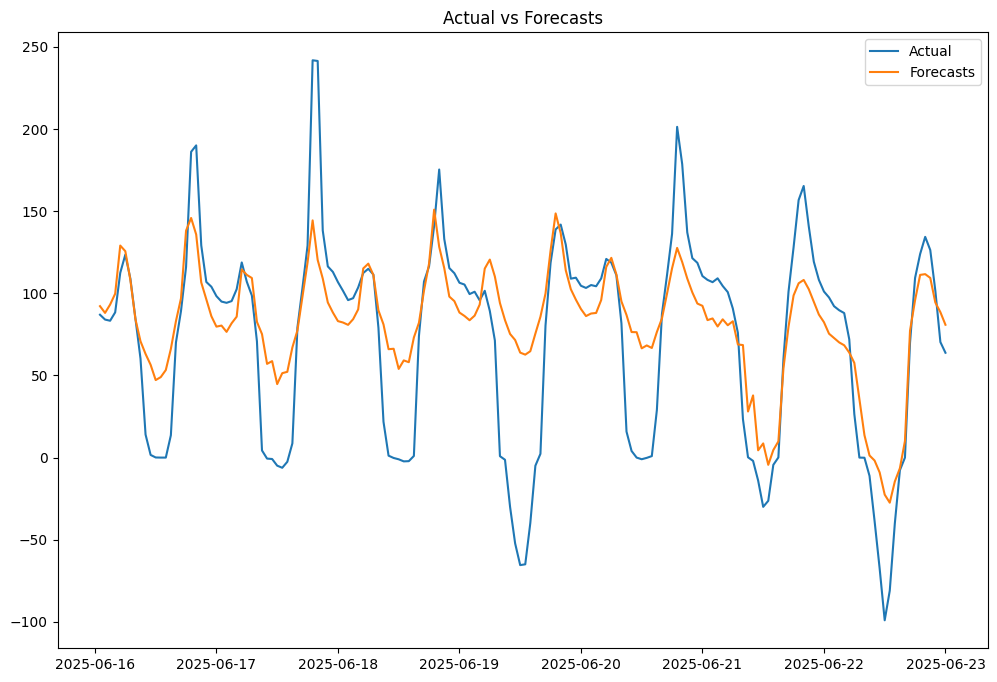

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(pd.to_datetime(actual_data['_time']), actual_data['Deutchland/Luxembourg'], label='Actual')
plt.plot(pd.to_datetime(data['_time'][48:]), data['Deutchland/Luxembourg'][48:], label='Forecasts')
plt.legend()
plt.title("Actual vs Forecasts")
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(actual_data['Deutchland/Luxembourg'], data['Deutchland/Luxembourg'][48:])
mae = mean_absolute_error(actual_data['Deutchland/Luxembourg'], data['Deutchland/Luxembourg'][48:])
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1767.5796335474104
Mean Absolute Error: 31.02155688021864


In [18]:
print(data[48:].describe())
print(actual_data.describe())

       Deutchland/Luxembourg
count             168.000000
mean               81.675152
std                34.254338
min               -27.441008
25%                67.953075
50%                84.677006
75%               101.871252
max               150.888962
       Deutchland/Luxembourg
count             168.000000
mean               71.440536
std                64.125130
min               -99.010000
25%                 1.125000
50%                95.095000
75%               111.105000
max               241.800000


In [19]:
# testing
a = tf.cast(tf.math.less_equal(-5.2, 0), tf.float32)
print(a.numpy())

1.0
